from google.colab import drive

drive.mount('/content/drive')

#**1. Install Dependencies and Setup**

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

#**2. Remove dodgy images**

In [4]:
import cv2
import imghdr

In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/data'

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

#**3. Load Data**

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/data')

Found 303 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

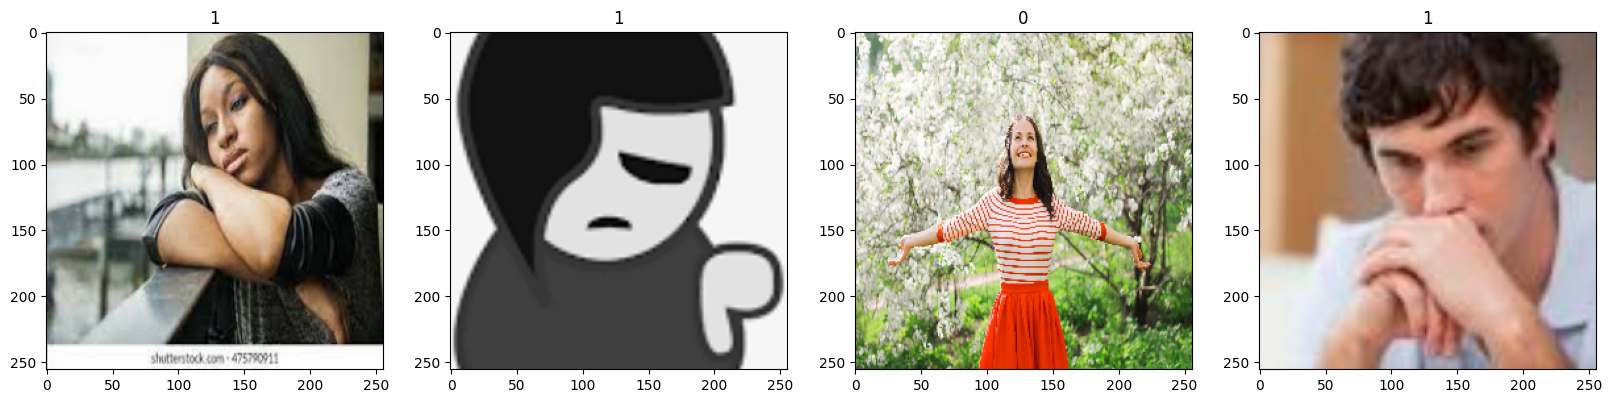

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#**4. Scale Data**

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.53728133, 0.47058824, 0.2901961 ],
          [0.53777295, 0.4750279 , 0.282871  ],
          [0.52523386, 0.47033188, 0.28402674],
          ...,
          [0.78078073, 0.64964205, 0.53066385],
          [0.7597454 , 0.63921845, 0.5172877 ],
          [0.7407782 , 0.62039745, 0.50637674]],
 
         [[0.53589153, 0.46922487, 0.28883272],
          [0.52977115, 0.4748692 , 0.28271234],
          [0.52435815, 0.46922487, 0.2705898 ],
          ...,
          [0.7848805 , 0.65546876, 0.5280484 ],
          [0.7604249 , 0.6466994 , 0.5224041 ],
          [0.7426596 , 0.62725186, 0.5129694 ]],
 
         [[0.53620356, 0.4731924 , 0.28149918],
          [0.53343743, 0.47731468, 0.27774203],
          [0.5326543 , 0.4748443 , 0.27873522],
          ...,
          [0.78141075, 0.6578278 , 0.5304303 ],
          [0.7597902 , 0.64303315, 0.52526355],
          [0.7448989 , 0.6259344 , 0.5161305 ]],
 
         ...,
 
         [[0.44069752, 0.49467164, 0.5590977 ],
          [0.46656

#**5. Split Data**

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#**6. Build Deep Learning Model**

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

#**7. Train**

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 21s 2s/step - loss: 0.9094 - accuracy: 0.5536 - val_loss: 0.6583 - val_accuracy: 0.5781
Epoch 2/20
7/7 [==============================] - 25s 3s/step - loss: 0.6204 - accuracy: 0.6250 - val_loss: 0.5269 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 20s 2s/step - loss: 0.5396 - accuracy: 0.7366 - val_loss: 0.4247 - val_accuracy: 0.8906
Epoch 4/20
7/7 [==============================] - 20s 3s/step - loss: 0.4212 - accuracy: 0.8438 - val_loss: 0.2606 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 20s 2s/step - loss: 0.3411 - accuracy: 0.8750 - val_loss: 0.2486 - val_accuracy: 0.9688
Epoch 6/20
7/7 [==============================] - 20s 3s/step - loss: 0.2778 - accuracy: 0.9152 - val_loss: 0.2140 - val_accuracy: 0.9688
Epoch 7/20
7/7 [==============================] - 20s 3s/step - loss: 0.1860 - accuracy: 0.9464 - val_loss: 0.1486 - val_accuracy: 0.9531
Epoch 8/20
7/7 [==================

#**8. Plot Performance**

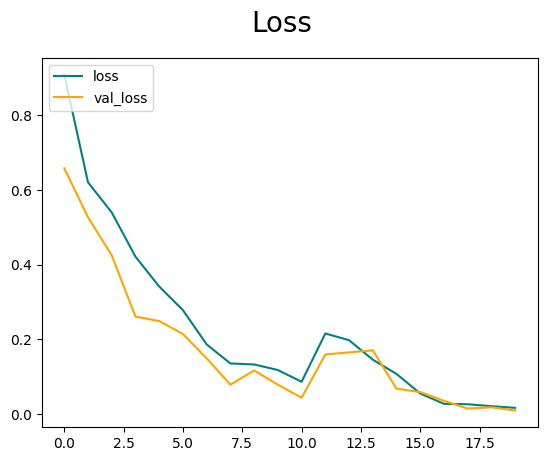

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

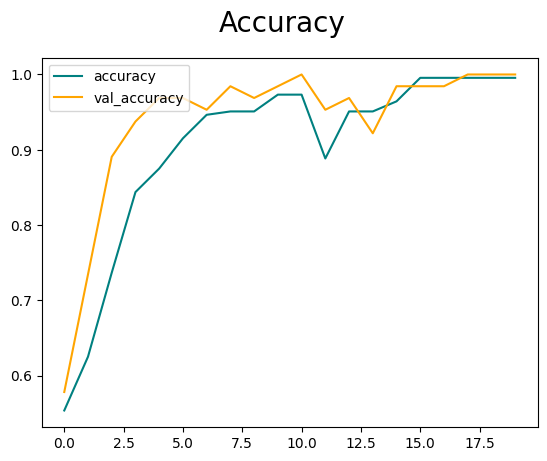

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#**9. Evaluate**

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 313ms/step


In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#**10. Test**

In [33]:
import cv2

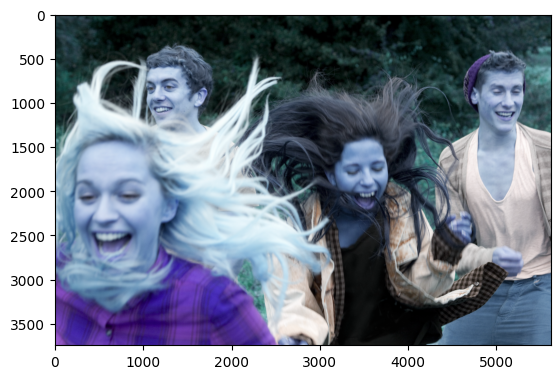

In [34]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/154006829.jpg')
plt.imshow(img)
plt.show()

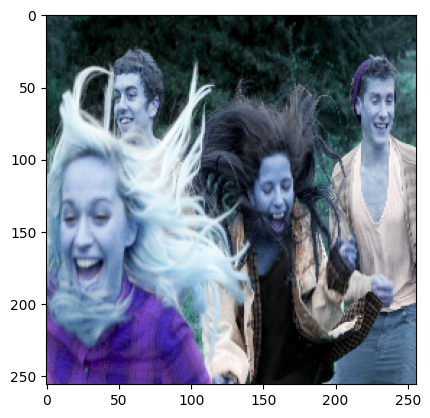

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 65ms/step


In [37]:
yhat

array([[0.01390149]], dtype=float32)

In [38]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


#**11. Save the Model**

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/Untitled Folder','/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning Projects/Youtube/Image Classifier/imageclassifier.h5')

In [42]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 97ms/step


array([[0.01390149]], dtype=float32)